In [1]:

#initialization
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile, BasicAer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy


# import basic plot tools
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.tools.monitor import job_monitor

## Problem: 

Create a circuit that outputs the subsets containing combinations of elements from [ 5, 7, 8, 9, 1] that add up to 16


## Brief explanation of code:

I will map the vector [ 5, 7, 8, 9, 1] to a quantum register of length 5 in which a 1 means that the element is included in the final output as a solution.

Example:
[5,9,1] == [1,0,0,1,1]

Then, I will use 5 ancilla qubits for the Grover's oracle since the bit representation of 16 is 10000. In our case, the verification will be done inverted for ease of implementation, i.e. I will verify that the values match to 00001 (see Grover section for better clarification).

In addition, the grover's oracle will be implemented with a 6th qubit (oracle output) that will be initialized in the $|-\rangle$ state to mark our solutions.

The final output of our circuit after measuring the first 5 qubits in the computational basis will be the solutions to our problem in the bit format explained above. We expect to see:

- [01010] == [7,9] and 
- [01101] == [7,8,1]


**Note:** Qiskit uses an inverse notation, so in our graph we will have to read the answer from the bit closer to the graph to the farthest. 

## QFT/IQFT

In [2]:
#This part contains the necessary functions for implementing QFT and IQFT

def qft_rotations(circuit, n):
    """Applies the phase gate rotations according to qft (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    #hadarmard gate on the nth qubit
    circuit.h(n)
    for qubit in range(n):
        #applies controlled phase gates
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    """ Swaps the qubits as the order is inverted"""
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """Applies QFT on the first n qubits in the circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit


def inverse_qft(circuit, n):
    """Applies  inverse QFT (IQFT) on the first n qubits in the circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit to obtain: IQFT
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

In [3]:
# Sub-circuit for QFT-gate
nqubits = 5 #length of input vector
sub1 = QuantumCircuit(nqubits,name='qft')
qft(sub1,nqubits)
#create QFT gate
qft_gate = sub1.to_instruction()

#Sub-cricuit for IQFT-gate
sub2 = QuantumCircuit(nqubits,name='iqft')
sub2 = inverse_qft(sub2, nqubits)
#create IQFT gate
iqft_gate = sub2.to_instruction()

## Grover

In [4]:
#First solution: Verifies if input qubits are in state [0,1,1,0,1] == [7,8,1] 
#if so, applies a pi phase gate to the first ancilla qubit to obtain 00001 as output after the IQFT

grover1 = QuantumCircuit(6, name='Solution_1') #1-5th qubit: correspond

#Controlled qubits are switched to check for '0' instead of the usual '1' by applying an X gate.
grover1.x(0)
grover1.x(3)
grover1.mcp(pi,[0,1,2,3,4],5)
grover1.x(0)
grover1.x(3)

#create gate for checking this first solution
controlled1 = grover1.to_instruction()
grover1.draw()

┌───┐       ┌───┐
q_0: ┤ X ├─■─────┤ X ├
     └───┘ │     └───┘
q_1: ──────■──────────
           │          
q_2: ──────■──────────
     ┌───┐ │     ┌───┐
q_3: ┤ X ├─■─────┤ X ├
     └───┘ │     └───┘
q_4: ──────■──────────
           │P(π)      
q_5: ──────■──────────

In [5]:
#Second solution: Verifies if input qubits are in state [0,1,0,1,0] == [7,9]
#if so, applies a pi phase gate to the first ancilla qubit to obtain 00001 as output after the IQFT

grover2 = QuantumCircuit(6, name='Solution_2')

grover2.x(0)
grover2.x(2)
grover2.x(4)
grover2.mcp(pi,[0,1,2,3,4],5)
grover2.x(0)
grover2.x(2)
grover2.x(4)

#create gate for checking this second solution
controlled = grover2.to_instruction()
grover2.draw()

┌───┐       ┌───┐
q_0: ┤ X ├─■─────┤ X ├
     └───┘ │     └───┘
q_1: ──────■──────────
     ┌───┐ │     ┌───┐
q_2: ┤ X ├─■─────┤ X ├
     └───┘ │     └───┘
q_3: ──────■──────────
     ┌───┐ │     ┌───┐
q_4: ┤ X ├─■─────┤ X ├
     └───┘ │P(π) └───┘
q_5: ──────■──────────

In [6]:
# Gate that checks the result obtained after the IQFT. Shits the controlled qubit if value is 16 == [0,0,0,0,1] (little endian)
#This will happen after applying the pi phase gate coming from either of the solutions

grover3 = QuantumCircuit(6, name='checking')

grover3.x(0)
grover3.x(1)
grover3.x(2)
grover3.x(3)
grover3.mct([0,1,2,3,4],5)
grover3.x(0)
grover3.x(1)
grover3.x(2)
grover3.x(3)

#gate to check the value after the QFT - phase gate - IQFT to correspond to 16
controlled_anc = grover3.to_instruction()
grover3.draw()

┌───┐     ┌───┐
q_0: ┤ X ├──■──┤ X ├
     ├───┤  │  ├───┤
q_1: ┤ X ├──■──┤ X ├
     ├───┤  │  ├───┤
q_2: ┤ X ├──■──┤ X ├
     ├───┤  │  ├───┤
q_3: ┤ X ├──■──┤ X ├
     └───┘  │  └───┘
q_4: ───────■───────
          ┌─┴─┐     
q_5: ─────┤ X ├─────
          └───┘

In [7]:
def initialize_s(qc, qubits):
    """Apply an H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc



def oracle(grover):
    
    """First Part of Grover's iteration. Oracle marks with a minus sign the solution states. 
    Equivalent to a reflection of the initial state around the state made of superpositions of non-solutions"""
    
    #Oracle implementation
    
    grover.append(qft_gate, [5,6,7,8,9])

    grover.append(controlled1, [0,1,2,3,4,5])
    
    grover.append(controlled, [0,1,2,3,4,5])

    grover.append(iqft_gate, [5,6,7,8,9])

    grover.append(controlled_anc, [5,6,7,8,9,10])

    #uncomputing oracle to return ancilla qubits to |00000> state for its use in grover's iteration
    
    grover.append(iqft_gate, [5,6,7,8,9])

    grover.append(controlled, [0,1,2,3,4,5])
    
    grover.append(controlled1, [0,1,2,3,4,5])

    grover.append(qft_gate, [5,6,7,8,9])
    
def diffuser(nqubits):
    
    """Second part of Grover's algorithm. Performs reflection around equal superposition state of nqubits
    In matrix notation: HX(MCZ)XH = U_s on n qubits"""
    
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

## Computations

In [10]:
arr = QuantumRegister(5,name='a') #qubits associated to the input vector
ancilla = QuantumRegister(5,name='b') #ancilla qubits for oracle
out = QuantumRegister(1,name='out') #output ancilla qubit of oracle that helps mark the solutions
cbits = ClassicalRegister(5, name='cbits') #classical bits for final measurement

grover = QuantumCircuit(arr,ancilla,out,cbits)

# Initialize 'out' in state |->
grover.initialize([1, -1]/np.sqrt(2), out)

#initialize 'arr' in equal superposition
grover = initialize_s(grover, [0,1,2,3,4]) 

grover.barrier()  # for visual separation

#r == number of iterations. The expected #iterations needed to obtain at least one of the solutions with high
# probability is pi/4 * sqrt(N/M). r = \bigO(sqrt(M/N)) oracle calls needed.
#N := #elements of search space = 2^n 
#n := #of elements in array (#qubits)
#M = #of solutions. 
#Here M = 2 and N = 32 => r = pi. 

r = 3

for i in range(r):
    oracle(grover) #oracle
    grover.append(diffuser(5), [0,1,2,3,4]) #diffuser 
    grover.barrier()  # for visual separation


# Measure the 'arr' qubits in computational basis and store results in classical bits 'cbits'
grover.measure(arr, cbits)

#Display circuit in one line
grover.draw(fold=-1)

┌───┐               ░         ┌─────────────┐┌─────────────┐                               ┌─────────────┐┌─────────────┐┌────────┐ ░         ┌─────────────┐┌─────────────┐                               ┌─────────────┐┌─────────────┐┌────────┐ ░         ┌─────────────┐┌─────────────┐                               ┌─────────────┐┌─────────────┐┌────────┐ ░ ┌─┐            
    a_0: ─────────────┤ H ├───────────────░─────────┤0            ├┤0            ├───────────────────────────────┤0            ├┤0            ├┤0       ├─░─────────┤0            ├┤0            ├───────────────────────────────┤0            ├┤0            ├┤0       ├─░─────────┤0            ├┤0            ├───────────────────────────────┤0            ├┤0            ├┤0       ├─░─┤M├────────────
                      ├───┤               ░         │             ││             │                               │             ││             ││        │ ░         │             ││             │                               │             ││             ││        │ ░         │             ││             │                               │             ││             ││        │ ░ └╥┘┌─┐         
    a_1: ─────────────┤ H ├───────────────░─────────┤1            ├┤1            ├───────────────────────────────┤1            ├┤1            ├┤1       ├─░─────────┤1            ├┤1            ├───────────────────────────────┤1            ├┤1            ├┤1       ├─░─────────┤1            ├┤1            ├───────────────────────────────┤1            ├┤1            ├┤1       ├─░──╫─┤M├─────────
                      ├───┤               ░         │             ││             │                               │             ││             ││        │ ░         │             ││             │                               │             ││             ││        │ ░         │             ││             │                               │             ││             ││        │ ░  ║ └╥┘┌─┐      
    a_2: ─────────────┤ H ├───────────────░─────────┤2            ├┤2            ├───────────────────────────────┤2            ├┤2            ├┤2 U$_s$ ├─░─────────┤2            ├┤2            ├───────────────────────────────┤2            ├┤2            ├┤2 U$_s$ ├─░─────────┤2            ├┤2            ├───────────────────────────────┤2            ├┤2            ├┤2 U$_s$ ├─░──╫──╫─┤M├──────
                      ├───┤               ░         │  Solution_1 ││  Solution_2 │                               │  Solution_2 ││  Solution_1 ││        │ ░         │  Solution_1 ││  Solution_2 │                               │  Solution_2 ││  Solution_1 ││        │ ░         │  Solution_1 ││  Solution_2 │                               │  Solution_2 ││  Solution_1 ││        │ ░  ║  ║ └╥┘┌─┐   
    a_3: ─────────────┤ H ├───────────────░─────────┤3            ├┤3            ├───────────────────────────────┤3            ├┤3            ├┤3       ├─░─────────┤3            ├┤3            ├───────────────────────────────┤3            ├┤3            ├┤3       ├─░─────────┤3            ├┤3            ├───────────────────────────────┤3            ├┤3            ├┤3       ├─░──╫──╫──╫─┤M├───
                      ├───┤               ░         │             ││             │                               │             ││             ││        │ ░         │             ││             │                               │             ││             ││        │ ░         │             ││             │                               │             ││             ││        │ ░  ║  ║  ║ └╥┘┌─┐
    a_4: ─────────────┤ H ├───────────────░─────────┤4            ├┤4            ├───────────────────────────────┤4            ├┤4            ├┤4       ├─░─────────┤4            ├┤4            ├───────────────────────────────┤4            ├┤4            ├┤4       ├─░─────────┤4            ├┤4            ├───────────────────────────────┤4            ├┤4            ├┤4       ├─░──╫──╫──╫──╫─┤M├
                      └───┘               ░ ┌──────┐│         

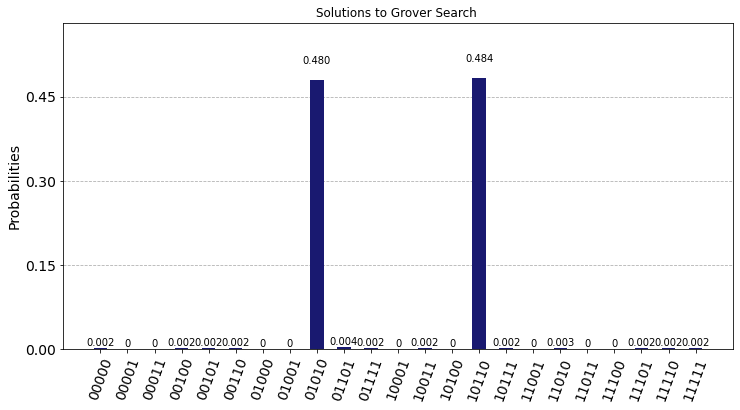

In [26]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(grover, backend)
plot_histogram(job.result().get_counts(),figsize=(12, 6), color='midnightblue', title="Solutions to Grover Search ")
# add filename='./Probabilities.jpg' to save graph

## Solution:

The grover search correctly outputs the two solutions [01010] == [7,9] and [01101] == [7,8,1] that add up to 16.

For this particular scenario, the solutions could be classically calculated and verified, thus the oracle was implemented in this specific way. In order to generalize this solution, the oracle would have to be built differenlty. Nonetheless, the use of controlled phase gates together with QFT and IQFT (inspired by the Adder circuit) can be leveraged to perform this search generally for any input array of numbers and desired integer output.

References:

- Quantum Computation and Quantum Information, Michael A. Nielsen, Isaac L. Chuang, Massachusetts Institute of Technology, 2010
- Addition on a Quantum Computer, Thomas G. Draper, June 15, 2000. (https://arxiv.org/pdf/quant-ph/0008033.pdf)
- https://qiskit.org/textbook/ch-algorithms/grover.html#5.2-Uncomputing,-and-Completing-the-Oracle
- https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html